Reference:
Race simulator for Matlab developed by AJK Phillips, 2014.
Credit to AJK Phillips and http://f1metrics.wordpress.com/

The GitHub link below is from another person who uploaded the code by Phillips, who used to put his MATLAB code on Google Drive. (For more details, check the link below)

https://github.com/syllogismos/F1Sim

# RaceSim

For the simulation to run, we need to define the track variables and the driver variables, and import the data we get from DataAnalysis (i.e. the data from Free Practice(s) and Qualifying) to initialize these variables.



## Track Variables

Track variables include:

- Name
- Number of Laps
- Lap Length
- Race Length
- Tyre variables (provided by Pirelli) 
    - Traction
    - Braking
    - Lateral
    - Tyre Stress
    - Track Evolution
    - Asphalt Grip
    - Asphalt Abrasion
    - Downforce

- Fuel Gain (refer to external sources)
- DNF Factor (The likelihood of retirements as race goes on, this value is compounded by laps elapsed (?))
- Safety Car (SC) variables (Could be extended to VSC)
    - Probability of SC
    - Number of Laps per SC period
    - Laptime of SC
    - Closest time gap between cars during the safety car period
    - Pit Window (Laps for pit window under safety car, i.e. Safety Car Window)
    
- Pit variables
    - In lap time loss
    - Out lap time loss
    
- Racing variables
    - Time gained per lap due to DRS
    - Additional tyre wear (in laps) per lap due to DRS
    - Overtaking variables
        - Distance (in seconds) which the car can follow the closest
        - Time loss (in seconds) due to being overtaken. Does not account for resistance (e.g. blocking or slowing down intentionally)
        - Overtaking Threshold (in seconds), i.e. the time needed to attempt to overtake
        
- Start Time standard deviation (???)

- Time difference between fresh tyre compounds
- Relative wear of different compounds
- Wear factor for track (Can be pulled from Pirelli's infographics)

## Driver Variables

Driver variables include:

- name
- Pit Strategy (Predefined, optional strategy)
- Lap Time Standard Deviation, i.e. the variability of their laptimes
- (For plotting) Driver Team Color

## Race Variables

Race variables include:

- Starting Grid Order
- Teammate pairing (Could be considered as a Driver variable)

#### FP2 and Qualifying Teammates Head-to-Head

In [1]:
import fastf1 as ff1
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
from race import *
from qualifying import *
from constants import *
from practice import *
from race_sim import *
from scipy import stats
from scipy.optimize import curve_fit

# Enable the cache by providing the name of the cache folder
ff1.Cache.enable_cache('cache')

%store -r fp2_race_sim
%store -r times_df

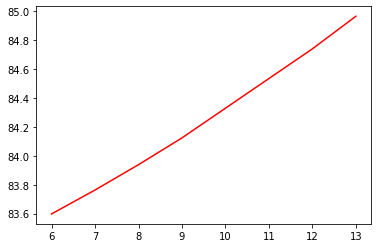

In [2]:
driver = 'RIC'
trackwear = 10

laptimes = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapTimes.tolist()[0]
laps = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapNumbers.tolist()[0]
laptimes = np.array(laptimes)
laps = np.array(laps)




popt, pcov, model = laptime_model(laps, laptimes, trackwear)
plt.plot(laps, model(laps, *popt), 'r-')
plt.show()

In [3]:
popt[0]

82.81816666684516

In [4]:
TEAMMATE_MAX_GAP_SECOND = 1
QUALIFYING_MAX_GAP_PERCENTAGE = 1.02
FP2_MAX_GAP_PERCENTAGE = 1.03

QUALIFYING_MIN_LAPTIME = times_df['Fastest Lap'].min()

FP2_MIN_MEDIAN_LAPTIME = fp2_race_sim['MeanLapTime'].median()

In [5]:


teammates_h2h = pd.DataFrame(columns = ['Driver', 'GoodFP2', 'GoodQualifying', 'Teammate',  'FP2MeanLapTime',  'TeammateFP2MeanLapTime', 
                                        'QualifyingLapTime', 'TeammateQualifyingLapTime',  'QualifyingPosition','TeammateQualifyingPosition'])
teammates_h2h

# To be inserted into teammates_h2h
for driver in TEAMMATE_PAIRS_DICT.keys():
    teammate = TEAMMATE_PAIRS_DICT[driver]
    
    # ".values[0]" extracts the values from the series/dataframe and index 0 extracts the first value, which should be the sole value.
    
    # FP2
    fp2_mean_laptime = fp2_race_sim.loc[fp2_race_sim['Driver'] == driver, 'MeanLapTime'].values[0]
    teammate_fp2_mean_laptime = fp2_race_sim.loc[fp2_race_sim['Driver'] == teammate, 'MeanLapTime'].values[0]
    
    # Qualifying
    q_fastest_lap = times_df.loc[times_df['Abbreviation'] == driver, 'Fastest Lap'].values[0]
    teammate_q_fastest_lap = times_df.loc[times_df['Abbreviation'] == teammate, 'Fastest Lap'].values[0]
    q_position = times_df.index.get_loc(times_df[times_df['Abbreviation'] == driver].index[0]) + 1
    teammate_q_position = times_df.index.get_loc(times_df[times_df['Abbreviation'] == teammate].index[0]) + 1
    
    # Booleans of whether driver has a good qualifying and fp2 sim compared to his teammate
    good_qualifying = q_fastest_lap - teammate_q_fastest_lap < TEAMMATE_MAX_GAP_SECOND \
            and q_fastest_lap < QUALIFYING_MIN_LAPTIME * QUALIFYING_MAX_GAP_PERCENTAGE
    
    good_fp2 = fp2_mean_laptime - teammate_fp2_mean_laptime < TEAMMATE_MAX_GAP_SECOND \
            and fp2_mean_laptime < FP2_MIN_MEDIAN_LAPTIME * FP2_MAX_GAP_PERCENTAGE
    
    teammates_h2h.loc[len(teammates_h2h)] = [driver, good_fp2, good_qualifying, teammate, 
                                             fp2_mean_laptime, teammate_fp2_mean_laptime, 
                                             q_fastest_lap, teammate_q_fastest_lap, 
                                             q_position, teammate_q_position]
    
teammates_h2h = teammates_h2h.round({'FP2MeanLapTime': 3, 'TeammateFP2MeanLapTime': 3}).sort_values('QualifyingPosition').reset_index(drop=True)

teammates_h2h

,Driver,GoodFP2,GoodQualifying,Teammate,FP2MeanLapTime,TeammateFP2MeanLapTime,QualifyingLapTime,TeammateQualifyingLapTime,QualifyingPosition,TeammateQualifyingPosition
0,RUS,False,True,HAM,85.315,80.853,77.377,78.035,1,7
1,SAI,True,True,LEC,83.624,83.698,77.421,77.567,2,3
2,LEC,True,True,SAI,83.698,83.624,77.567,77.421,3,2
3,NOR,True,True,RIC,83.917,84.187,77.769,78.198,4,9
4,OCO,True,True,ALO,84.055,85.103,78.018,77.904,5,6
5,ALO,False,True,OCO,85.103,84.055,77.904,78.018,6,5
6,HAM,True,True,RUS,80.853,85.315,78.035,77.377,7,1
7,BOT,True,True,ZHO,83.834,85.335,78.157,78.573,8,12
8,RIC,True,True,NOR,84.187,83.917,78.198,77.769,9,4
9,VER,True,True,PER,84.173,84.782,77.703,78.516,10,11


In [6]:
trackwear = 10
teammates_h2h['BaseTime'] = np.NaN

for driver in TEAMMATE_PAIRS_DICT.keys():
    
    laptimes = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapTimes.tolist()[0]
    laps = fp2_race_sim[fp2_race_sim['Driver'] == driver].LapNumbers.tolist()[0]
    laptimes = np.array(laptimes)
    laps = np.array(laps)

    if len(laps) > 2:
        popt, pcov, model = laptime_model(laps, laptimes, trackwear)
        teammates_h2h.loc[teammates_h2h['Driver'] == driver, 'BaseTime'] = popt[0]
    else:
        teammates_h2h.loc[teammates_h2h['Driver'] == driver, 'BaseTime'] = 10000
    
teammates_h2h = teammates_h2h.sort_values('BaseTime').reset_index(drop=True)
teammates_h2h

,Driver,GoodFP2,GoodQualifying,Teammate,FP2MeanLapTime,TeammateFP2MeanLapTime,QualifyingLapTime,TeammateQualifyingLapTime,QualifyingPosition,TeammateQualifyingPosition,BaseTime
0,SAI,True,True,LEC,83.624,83.698,77.421,77.567,2,3,80.979000
1,VER,True,True,PER,84.173,84.782,77.703,78.516,10,11,81.174250
2,LEC,True,True,SAI,83.698,83.624,77.567,77.421,3,2,81.424000
3,PER,True,True,VER,84.782,84.173,78.516,77.703,11,10,81.900500
4,VET,True,False,STR,84.585,84.798,79.273,79.137,18,14,82.057500
5,TSU,True,False,GAS,85.502,85.302,79.240,79.527,16,19,82.133583
6,ALO,False,True,OCO,85.103,84.055,77.904,78.018,6,5,82.310900
7,NOR,True,True,RIC,83.917,84.187,77.769,78.198,4,9,82.363857
8,STR,True,False,VET,84.798,84.585,79.137,79.273,14,18,82.495200
9,MAG,True,True,MSC,85.828,86.678,78.825,79.164,13,15,82.713100


In [24]:
MAX_GAP_VALUE = 20

for driver in TEAMMATE_PAIRS_DICT.keys():
    self_row = teammates_h2h[teammates_h2h['Driver'] == driver]
    
    # Qualifying
    self_q_time = float(self_row.QualifyingLapTime)
    min_q_time = min(teammates_h2h.QualifyingLapTime)
    quali_gap = min(self_q_time - min_q_time, MAX_GAP_VALUE)
    
    # FP2
    self_fp2_time = float(self_row.BaseTime)
    min_fp2_time =  min(teammates_h2h.BaseTime)
    
    fp2_gap = min(self_fp2_time - min_fp2_time , MAX_GAP_VALUE)

    good_fp2 = self_row.GoodFP2.iloc[0]
    good_quali = self_row.GoodQualifying.iloc[0]
    if good_fp2 or good_quali:
        teammates_h2h.loc[teammates_h2h['Driver'] == driver, 'LongRunEstimate'] = \
            min(teammates_h2h.BaseTime) + good_fp2 * (1 - 0.5 * good_quali) * fp2_gap + good_quali * (1 - 0.5 * good_fp2) * quali_gap
    else:
        teammate_row = teammates_h2h[teammates_h2h['Driver'] == TEAMMATE_PAIRS_DICT[driver]]
        fp2_gap = min(float(teammate_row.BaseTime) - min_fp2_time + 1, MAX_GAP_VALUE)
        quali_gap =  min(float(teammate_row.BaseTime) - min_q_time + 1, MAX_GAP_VALUE)
        teammates_h2h.loc[teammates_h2h['Driver'] == driver, 'LongRunEstimate'] = \
            min(teammates_h2h.BaseTime) + (1 - 0.5 * (quali_gap < 10)) * fp2_gap + good_quali * (1 - 0.5 * (fp2_gap < 10)) * quali_gap
    
            
teammates_h2h = teammates_h2h.sort_values('BaseTime').reset_index(drop=True)
teammates_h2h

,Driver,GoodFP2,GoodQualifying,Teammate,FP2MeanLapTime,TeammateFP2MeanLapTime,QualifyingLapTime,TeammateQualifyingLapTime,QualifyingPosition,TeammateQualifyingPosition,BaseTime,LongRunEstimate
0,SAI,True,True,LEC,83.624,83.698,77.421,77.567,2,3,80.979000,81.001000
1,VER,True,True,PER,84.173,84.782,77.703,78.516,10,11,81.174250,81.239625
2,LEC,True,True,SAI,83.698,83.624,77.567,77.421,3,2,81.424000,81.296500
3,PER,True,True,VER,84.782,84.173,78.516,77.703,11,10,81.900500,82.009250
4,VET,True,False,STR,84.585,84.798,79.273,79.137,18,14,82.057500,82.057500
5,TSU,True,False,GAS,85.502,85.302,79.240,79.527,16,19,82.133583,82.133583
6,ALO,False,True,OCO,85.103,84.055,77.904,78.018,6,5,82.310900,81.506000
7,NOR,True,True,RIC,83.917,84.187,77.769,78.198,4,9,82.363857,81.867429
8,STR,True,False,VET,84.798,84.585,79.137,79.273,14,18,82.495200,82.495200
9,MAG,True,True,MSC,85.828,86.678,78.825,79.164,13,15,82.713100,82.570050
